In [1]:
import json
import pandas as pd
import networkx as nx
import seaborn as sns
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

In [22]:
expert_network = json.load(open('expert_network.json'))

In [34]:
num_follower = [len(expert_network[k]['followers']) for k in expert_network]

In [36]:
sum(np.array(num_follower) < 10)/ len(num_follower)

0.020289855072463767

In [2]:
expert_network = json.load(open('expert_network.json'))
data = pd.read_csv('complete_data.csv')
data = data[(data['twitter'].isin(expert_network)) & (data['twitter'] != 'Twitter')]
aei = data[data['institution']=='aei']['twitter']
cap = data[data['institution']=='cap']['twitter']
brookings = data[data['institution']=='brookings']['twitter']
heritage = data[data['institution']=='heritage']['twitter']

In [10]:
expert_institution = dict(zip(data['twitter'], data['institution']))

In [3]:
from_node, to_node = [], []
for expert in expert_network:
    followers = expert_network[expert]['followers']
    following = expert_network[expert]['following']
    from_node.extend(followers)
    to_node.extend([expert]*len(followers))
    from_node.extend([expert]*len(following))
    to_node.extend(following)

## G: Complete Graph 
## H: Top500 Graph for Visualization

In [4]:
network_data = pd.DataFrame({'from': from_node, 
                             'to': to_node}).drop_duplicates()
G = nx.DiGraph()
for num, row in network_data.iterrows():
    G.add_edge(row['from'], row['to'])

In [5]:
network_data = pd.DataFrame({'from': from_node, 'to': to_node}).drop_duplicates()
target_network = network_data[network_data['from'].isin(expert_network) &
                              network_data['to'].isin(expert_network)]
E = nx.DiGraph()
for num, row in target_network.iterrows():
    E.add_edge(row['from'], row['to'])

In [11]:
expert_institution['AmyAndersonDNP']

'heritage'

In [17]:
target_network = target_network.copy()
target_network['from_insitution'] = target_network['from'].apply(lambda x: expert_institution[x] 
                                                                 if x in expert_institution else np.nan)
target_network['to_insitution'] = target_network['to'].apply(lambda x: expert_institution[x]
                                                            if x in expert_institution else np.nan)
target_network['share_institution'] = target_network['from_insitution'] == target_network['to_insitution']

In [18]:
pd.crosstab(target_network['from_insitution'], target_network['share_institution'])

share_institution,False,True
from_insitution,,
aei,892,1516
brookings,1439,6000
cap,1212,5594
heritage,912,3563


In [37]:
892/(892+1516), 1439/(1439+6000), 1212/(1212+5594), 912/(912+3563)

(0.3704318936877076,
 0.19343997849173275,
 0.17807816632383192,
 0.20379888268156424)

In [97]:
mutual_edges = {}
count = 0
for expert in expert_network:
    following = list(target_network[target_network['from']==expert]['to'])
    following_2nd = list(target_network[target_network['from'].isin(following)]['to'])
    follower = list(target_network[target_network['to']==expert]['from'])
    if len(follower)<2: 
        print(expert, end = '\r')
        count += 1
    
    try: mutual_edges[expert] = sum([i==expert for i in following_2nd])/len(following)
    except ZeroDivisionError: mutual_edges[expert] = np.NAN
np.nanmean(list(mutual_edges.values()))

0.578308720272108

In [6]:
from networkx import DiGraph
undirected_E = E.to_undirected()

In [7]:
data['mutual_degree'] = data['twitter'].apply(lambda x: 
                            len(list(undirected_E.neighbors(x))) if x in E.nodes() else np.NAN)

In [8]:
data['in_degree_total'] = data['twitter'].apply(lambda x: 
                            len(expert_network[x]['followers']) if x in expert_network else np.NAN)
data['out_degree_total'] = data['twitter'].apply(lambda x: 
                            len(expert_network[x]['following']) if x in expert_network else np.NAN)

In [9]:
centrality = nx.in_degree_centrality(E)
data['in_deg_centrality'] = data['twitter'].apply(lambda x: 
                            centrality[x]*len(centrality) if x in centrality else np.NAN)
centrality = nx.out_degree_centrality(E)
data['out_deg_centrality'] = data['twitter'].apply(lambda x: 
                            centrality[x]*len(centrality) if x in centrality else np.NAN)
centrality = nx.eigenvector_centrality(E)
data['eigenvector_centrality'] = data['twitter'].apply(lambda x: 
                            centrality[x] if x in centrality else np.NAN)
centrality = nx.closeness_centrality(E)
data['closeness_centrality'] = data['twitter'].apply(lambda x: 
                            centrality[x] if x in centrality else np.NAN)
centrality = nx.betweenness_centrality(E)
data['betweenness_centrality'] = data['twitter'].apply(lambda x: 
                            centrality[x] if x in centrality else np.NAN)

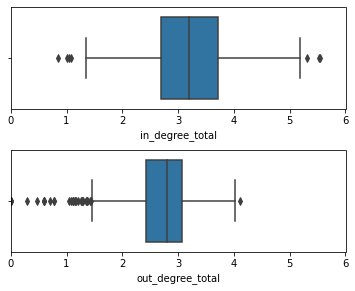

In [90]:
fig, axs = plt.subplots(2, 1, figsize = (6,4))

samp = data['in_degree_total'].replace(0, np.nan).dropna()
samp = np.log10(samp)
samp = samp.replace([np.inf, -np.inf], np.nan).dropna()
sns.boxplot(x=samp, ax = axs[0])
axs[0].set_xlim([0, 6])

samp = data['out_degree_total'].replace(0, np.nan).dropna()
samp = np.log10(samp)
samp = samp.replace([np.inf, -np.inf], np.nan).dropna()
sns.boxplot(x=samp, ax = axs[1])
axs[1].set_xlim([0, 6])

fig.subplots_adjust(bottom=0.05, top=0.9,hspace=0.4, wspace=0.3)

In [16]:
from networkx.algorithms.cluster import clustering
from sklearn.linear_model import LinearRegression

<AxesSubplot:xlabel='mutual_degree', ylabel='clustering_coeff'>

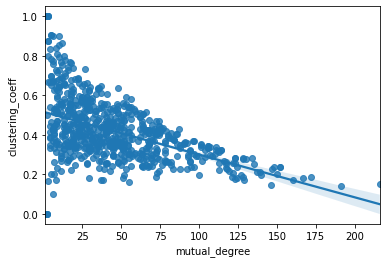

In [18]:
cluster = clustering(E)
data['clustering_coeff'] = data['twitter'].apply(lambda x: 
                            cluster[x] if x in cluster else np.NAN)
sns.regplot(x="mutual_degree", y="clustering_coeff", data=data)

In [19]:
sample = data[['mutual_degree', 'clustering_coeff']].dropna()
X = sample[['mutual_degree']]
y = sample['clustering_coeff']
reg = LinearRegression().fit(X, y)
print(reg.score(X, y))
print(reg.predict(np.array([[5]])), reg.predict(np.array([[20]])), 
      reg.predict(np.array([[100]])))

0.1923212962673445
[0.50555988] [0.47308869] [0.29990901]


2.691800190658498 0.6079504615805765


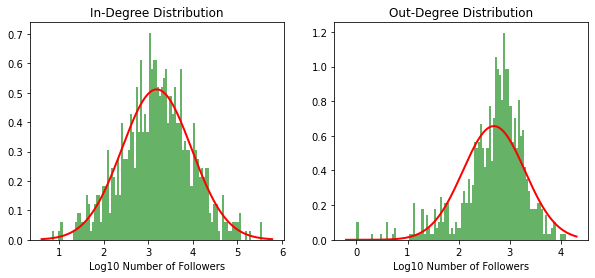

In [34]:
from scipy.stats import lognorm, norm
import math

fig, axs = plt.subplots(1, 2, figsize = (10,4))

samp = data['in_degree_total'].replace(0, np.nan).dropna()
samp = np.log10(samp)
samp = samp.replace([np.inf, -np.inf], np.nan).dropna()
axs[0].hist(samp, bins=100, density=True, alpha=0.6, color='g')
mu, std = norm.fit(samp)

xmin, xmax = axs[0].axis()[:2]
x = np.linspace(xmin, xmax, len(samp))
p = norm.pdf(x, mu, std)
axs[0].plot(x, p, 'k', linewidth=2, color= 'red')
axs[0].set_title('In-Degree Distribution')
axs[0].set_xlabel('Log10 Number of Followers')


samp = data['out_degree_total'].replace(0, np.nan).dropna()
samp = np.log10(samp)
samp = samp.replace([np.inf, -np.inf], np.nan).dropna()
axs[1].hist(samp, bins=100, density=True, alpha=0.6, color='g')
mu, std = norm.fit(samp)
print(mu, std)

xmin, xmax = axs[1].axis()[:2]
x = np.linspace(xmin, xmax, 1000)
p = norm.pdf(x, mu, std)
axs[1].plot(x, p, 'k', linewidth=2, color= 'red')
axs[1].set_title('Out-Degree Distribution')
axs[1].set_xlabel('Log10 Number of Followers')

plt.show()

In [54]:
samp = data['in_degree_total'].replace(0, np.nan).dropna()
samp = np.log10(samp)
samp = samp.replace([np.inf, -np.inf], np.nan).dropna()

(0.2698265553553155, -0.0012448419163090618, 3.0866406065146883)


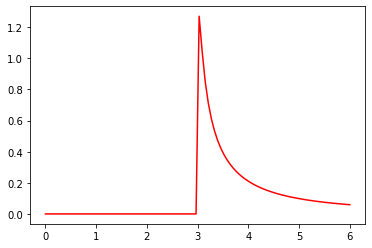

In [67]:
#samp = lognorm(0.5,loc=0,scale=1).rvs(size=2000) # sample
param = lognorm.fit(samp, loc=0) # fit the sample data
print(param) #shape/sigma, loc/mu, scale/median 
x=np.linspace(0,6,100)
#pdf_fitted = lognorm.pdf(x, param[0], loc=param[1], scale=param[2])
#pdf_fitted = lognorm.pdf(x, 1, loc=0, scale=1)
pdf_fitted = lognorm.pdf(x, math.sqrt(3.6), loc=3, scale=1)
plt.plot(x,pdf_fitted,'r-')
#plt.hist(samp,bins=100,density=True,alpha=.3)
plt.show()

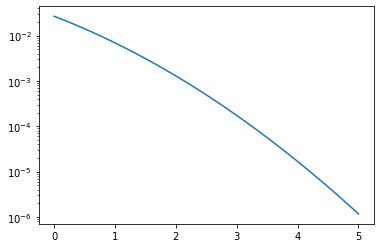

In [68]:
x = np.linspace(0, 5, 1000)
p = norm.pdf(x, -3.62, math.sqrt(3.05))
plt.yscale('log')
plt.plot(x, p)
plt.show()

In [334]:
3.010851690508058 1.102253794007616
3.0595917329329643 1.0815229098381927

954.8587570621469

In [339]:
data['in_degree_total'].mean()

7294.707627118644

In [12]:
data.to_csv('complete_data_centrality.csv', index=False)

In [20]:
data = pd.read_csv('complete_data_centrality.csv')

In [21]:
data

,expert_id,name,twitter,institution,type,title,num_opinions,num_testimony,num_press,num_external,is_resident,is_senior,is_leadership,is_phd,is_law,out_deg_centrality,eigenvector_centrality,closeness_centrality,betweenness_centrality,in_deg_centrality
0,samuel-j-abrams,Samuel J. Abrams,SamuelAbramsAEI,aei,NaN,Visiting Scholar,85,0,9,0,N,N,N,Y,N,0.093333,8.698648e-03,0.359261,1.231764e-03,0.013333
1,joseph-antos,Joseph Antos,joeantos,aei,NaN,Wilson H. Taylor Scholar in Health Care and Re...,144,0,34,0,Y,N,N,Y,N,0.007407,1.189104e-02,0.369375,3.419156e-04,0.025185
2,leon-aron,Leon Aron,AronRTTT,aei,NaN,"Resident Scholar; Director, Russian Studies",380,0,65,0,Y,N,Y,Y,N,0.019259,1.797268e-02,0.395593,2.422520e-04,0.026667
3,kirsten-axelsen,Kirsten Axelsen,kjacny,aei,NaN,Visiting Fellow,15,0,3,0,N,N,N,N,N,0.013333,5.043010e-04,0.286005,7.689147e-07,0.001481
4,john-bailey,John P. Bailey,John_Bailey,aei,NaN,Visiting Fellow,55,0,2,1,N,N,N,N,N,0.060741,1.445330e-02,0.398345,5.565939e-03,0.038519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,siddiqi-maggie,Maggie Siddiqi,MaggieM_S,cap,NaN,Director,15,0,0,0,Y,N,Y,N,N,0.091852,4.328820e-02,0.367007,1.529895e-03,0.065185
704,bachmann-christopher,Christopher Bachmann,chrisbachmann,cap,NaN,UNIX Systems Administrator,0,0,0,0,Y,N,N,N,N,0.000000,8.335054e-04,0.269389,0.000000e+00,0.002963
705,chambers-craig,Craig Chambers,plasticlicker,cap,NaN,"Director, Technology and Security",0,0,0,0,Y,N,Y,N,N,0.002963,1.139658e-91,0.000000,0.000000e+00,0.000000
706,simpson-erin,Erin Simpson,esmpsn,cap,NaN,Associate Director,3,0,0,0,Y,N,Y,N,N,0.034074,1.103106e-02,0.324130,1.556946e-04,0.014815


In [255]:
G_cent = nx.degree_centrality(G)
tar_nodes = top = [i[0] for i in sorted(G_cent.items(), key = lambda x: -x[1])[:600]]
print(len(tar_nodes))
network_data = pd.DataFrame({'from': from_node, 'to': to_node}).drop_duplicates()
target_network = network_data[network_data['from'].isin(tar_nodes) &
                              network_data['to'].isin(tar_nodes)]
K = nx.DiGraph()
for num, row in target_network.iterrows():
    K.add_edge(row['from'], row['to'])

600


In [261]:
H = E
pos = nx.spring_layout(H, k=0.3)
centrality_H = nx.degree_centrality(H)

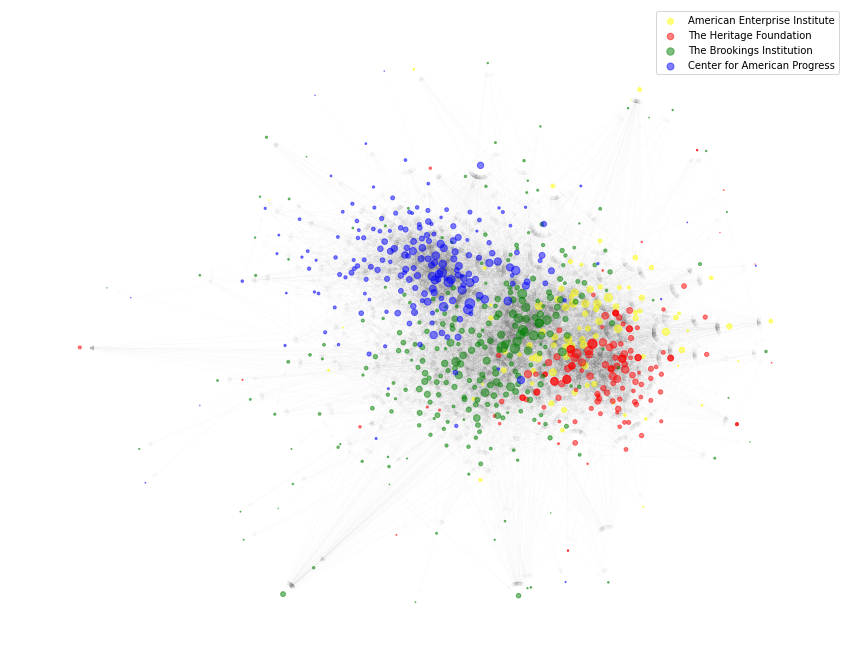

In [263]:
plt.figure(figsize=(15,12))
nx.draw_networkx_edges(H, pos, width=1.0, alpha=0.01)

nodelist = [ag for ag in aei if ag in H.nodes]
nx.draw_networkx_nodes(H, pos, nodelist= nodelist,
                       node_size= [centrality_H[i]*250 for i in nodelist],
                       node_color = 'yellow', 
                       label = 'American Enterprise Institute',
                       alpha=0.5)

nodelist = [ag for ag in heritage if ag in H.nodes]
nx.draw_networkx_nodes(H, pos, nodelist= nodelist,
                       node_size= [centrality_H[i]*250 for i in nodelist],
                       node_color = 'red', 
                       label = 'The Heritage Foundation',
                       alpha=0.5)

nodelist = [ag for ag in brookings if ag in H.nodes]
nx.draw_networkx_nodes(H, pos, nodelist= nodelist,
                       node_size= [centrality_H[i]*250 for i in nodelist],
                       node_color = 'green', 
                       label = 'The Brookings Institution',
                       alpha=0.5)

nodelist = [ag for ag in cap if ag in H.nodes]
nx.draw_networkx_nodes(H, pos, nodelist= nodelist,
                       node_size= [centrality_H[i]*250 for i in nodelist],
                       node_color = 'blue', 
                       label = 'Center for American Progress',
                       alpha=0.5)

plt.axis('off')
plt.legend()
plt.show()

In [259]:
extra

{'BrookingsInst'}

## Community Performance
1. requires strictly mutually excludable partition
2. consider only 1-degree connections
3. not variety

In [185]:
from networkx.algorithms.community.quality import performance, modularity,coverage
from networkx.algorithms.community.community_utils import is_partition

In [22]:
partition = []
recorded = []
for i in ['aei', 'brookings', 'heritage', 'cap']:
    add = [i for i in data[data['institution']==i]['twitter'] if i in E.nodes()]
    add = set(add)-set(recorded)
    partition.append(add)
    recorded.extend(add)
print(len(recorded), len(E.nodes))

675 676


In [17]:
modularity(E, partition)

0.5071391165066643

The coverage of a partition is the ratio of the number of intra-community edges to the total number of edges in the graph.

In [20]:
coverage(E, partition)

0.7883577670598347

## Deep Walk
https://www.analyticsvidhya.com/blog/2019/11/graph-feature-extraction-deepwalk/

In [5]:
import random
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from scipy import stats

In [113]:
color_dict = dict({'heritage':'red',
                   'aei': 'orange',
                   'brookings':'green',
                   'cap': 'blue'})

legnd_dict = dict({'heritage':'The Heritage Foundation',
                   'aei': 'American Enterprise Institute',
                   'brookings':'The Brookings Institution',
                   'cap': 'Center for American Progess'})

expert_institution = dict(zip(data['twitter'], data['institution']))

def get_randomwalk(node, path_length, graph):  
    random_walk = [node]  
    for i in range(path_length-1):
        temp = list(graph.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0: break
        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
    return random_walk

def plot_nodes(model, graph):
    word_list = list(graph.nodes())
    word_list = [w for w in word_list if w in model.wv]
    X = model.wv[word_list]
    result = TSNE(n_components=2).fit_transform(X)
    #result = PCA(n_components=2).fit_transform(X)
    dat = pd.DataFrame(result)
    dat.columns = ['A', 'B']
    expert_institution = dict(zip(data['twitter'], data['institution']))
    dat['label'] = [expert_institution[i] if i in expert_institution else 'other' for i in word_list]
    dat['name'] = [i if i in expert_institution else 'other' for i in word_list]
    
    plt.figure(figsize=(12,9))
    
    for key in legnd_dict:
        alpha = 1
        label = legnd_dict[key]
        tar = dat[dat['label']==key]
        #print(key, len(tar))
        p = sns.scatterplot(x=tar['A'], y=-tar['B'], 
                            #data = tar, 
                            alpha = alpha, 
                            color = color_dict[key], 
                            label = label) 
    return plt

def train_plot(graph, path_length, window):
    all_nodes = set(data['twitter']) & set(graph.nodes())
    random_walks = []
    for n in all_nodes:
        for i in range(30):
            random_walks.append(get_randomwalk(n, path_length, graph))

    model = Word2Vec(window = window, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

    model.build_vocab(random_walks, progress_per=2)
    model.train(random_walks, 
            total_examples = model.corpus_count, 
            epochs=20, report_delay=1)
    
    plt = plot_nodes(model, graph) ## random walk = 3
    plt.title(f'Path Length: {path_length}, Window: {window}')
    plt.axis('off')
    plt.show()
    
    for ins in ['aei', 'brookings', 'heritage', 'cap']:
        lst = [i for i in data[data['institution']==ins]['twitter'] if i in model.wv]
        data_wv = model.wv[lst]
        print(ins, stats.median_abs_deviation(data_wv, axis=None))

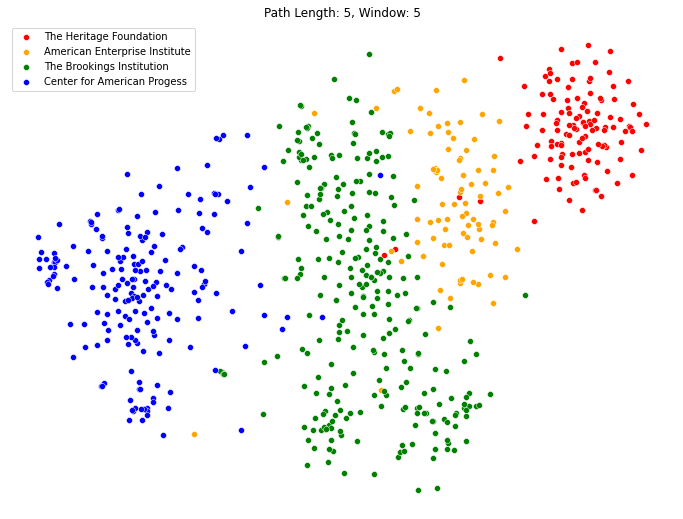

aei 0.23269522190093994
brookings 0.23661616444587708
heritage 0.2433527708053589
cap 0.23959572613239288


In [116]:
model = train_plot(E, 5, 5)

0.3251150558842867


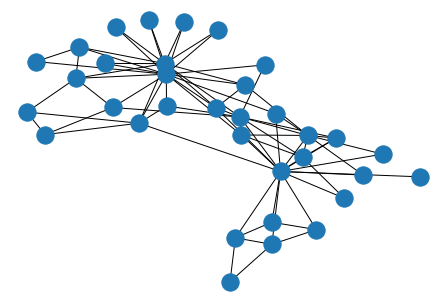

In [195]:
import networkx.algorithms.community as nx_comm
G = nx.karate_club_graph()
print(modularity(G, nx_comm.label_propagation_communities(G)))
nx.draw(G)

In [211]:
community

<generator object label_propagation_communities at 0x7faf03a45468>

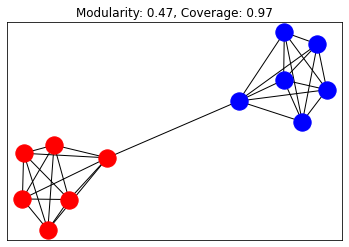

In [216]:
import networkx.algorithms.community as nx_comm
G = nx.barbell_graph(6,0)
#G = nx.karate_club_graph()

pos = nx.spring_layout(G, k=0.3)

community = list(nx_comm.label_propagation_communities(G))
mod = modularity(G, community)
cov = coverage(G, community)

nx.draw_networkx_edges(G, pos, width=1.0, alpha=1)
    
color = ['r', 'b', 'g']
for i, group in enumerate(community):
    nx.draw_networkx_nodes(G, pos, 
                           nodelist= group,
                           node_color = color[i])
    
plt.title('Modularity: {:0.2f}, Coverage: {:0.2f}'.format(mod, cov))
plt.show()

In [172]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(expert_lst, model = model.wv):
    return sum([normalize(model[x]) for x in expert_lst if x in model])/len(expert_lst)

def distance(expert, cent):
    if expert not in model.wv: return 0
    return math.sqrt(sum((model.wv[expert]-cent_aei)**2))

In [173]:
cent = dimension(data['twitter'])

In [174]:
cent_aei = dimension(data[data['institution']=='aei']['twitter'])
cent_brookings = dimension(data[data['institution']=='brookings']['twitter'])
cent_heritage = dimension(data[data['institution']=='heritage']['twitter'])
cent_cap = dimension(data[data['institution']=='cap']['twitter'])

In [175]:
for i in ['aei', 'brookings', 'heritage', 'cap']:
    lst = [i for i in data[data['institution']==i]['twitter'] 
           if i in model.wv]
    data_wv = model.wv[lst]
    mod = PCA(n_components=3).fit(data_wv)
    print(mod.explained_variance_)
    result = mod.transform(data_wv)
    print(i, np.var(result[:,0]))

aei 0.8618986
brookings 1.1206203
heritage 0.52164346
cap 0.6277976


## Centrality

In [222]:
data = pd.read_csv('complete_data.csv')

In [223]:
cent = nx.in_degree_centrality(E)
data['in_degree_centrality'] = data['twitter'].apply(lambda x: cent[x] if x in cent else np.NAN)
cent = nx.out_degree_centrality(E)
data['out_degree_centrality'] = data['twitter'].apply(lambda x: cent[x] if x in cent else np.NAN)
cent = nx.eigenvector_centrality(E)
data['eigenvector_centrality'] = data['twitter'].apply(lambda x: cent[x] if x in cent else np.NAN)
cent = nx.closeness_centrality(E)
data['closeness_centrality'] = data['twitter'].apply(lambda x: cent[x] if x in cent else np.NAN)
cent = nx.betweenness_centrality(E)
data['betweenness_centrality'] = data['twitter'].apply(lambda x: cent[x] if x in cent else np.NAN)
cent = nx.pagerank(E, alpha = 0.9)
data['pagerank_centrality'] = data['twitter'].apply(lambda x: cent[x] if x in cent else np.NAN)

In [224]:
def gini(list_of_values):
    sorted_list = sorted(list(list_of_values))
    height, area = 0, 0 
    for value in sorted_list:
        height += value
        area += height - value / 2.
        fair_area = height * len(list_of_values) / 2
    return (fair_area - area) / fair_area

In [225]:
data.shape

(1151, 25)

In [226]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
data = data[~data['twitter'].isin(['-1', 'Twitter', 'MarshallJenA', 'sarahfiggatt'])]
data = data.drop_duplicates(subset = ['twitter'])
experts_data = data[~data['type'].isin(['other', 'N'])].copy()
print(experts_data.shape)
experts_data = experts_data.drop(['type'], axis=1).dropna()
print(experts_data.shape)

if 'num_external' in experts_data.columns:
    experts_data['num_press'] = experts_data['num_press']+experts_data['num_external']
    experts_data = experts_data.drop(['num_external', 'name', 'title'], axis=1)

for col in experts_data.columns:
    if 'centrality' in col:
        print(col, gini(experts_data[col].dropna()))
    if ('num' in col) or ('centrality' in col) or (col=='tweet_freq'):
        scaler = MinMaxScaler(feature_range=(0, 1)).fit(experts_data[[col]])
        experts_data[col] = scaler.transform(experts_data[[col]])
    if ('is' in col):
        experts_data[col] = experts_data[col].apply(lambda x: x=='Y')

(619, 25)
(596, 24)
in_degree_centrality 0.4773975920508357
out_degree_centrality 0.461738515624686
eigenvector_centrality 0.5217741411239692
closeness_centrality 0.09372037624148208
betweenness_centrality 0.7477063916596021
pagerank_centrality 0.47757605048298407


In [227]:
import statsmodels.api as sm
experts_data = experts_data.dropna()
x_columns = list(experts_data.columns[4:-6])
X = experts_data[x_columns]
X_const = sm.add_constant(X)

In [178]:
x_columns

['num_testimony',
 'num_press',
 'is_resident',
 'is_senior',
 'is_leadership',
 'is_phd',
 'is_law',
 'num_tweets',
 'num_following',
 'num_followers',
 'tweet_freq']

In [228]:
for col in data.columns:
    if 'centrality' in col:
        print(f'\n{col}\n')
        y = experts_data[col]
        logit = sm.OLS(y, X_const.astype(float)).fit()
        print(logit.summary())


in_degree_centrality

                             OLS Regression Results                             
Dep. Variable:     in_degree_centrality   R-squared:                       0.463
Model:                              OLS   Adj. R-squared:                  0.453
Method:                   Least Squares   F-statistic:                     45.83
Date:                  Tue, 29 Sep 2020   Prob (F-statistic):           9.60e-72
Time:                          10:54:02   Log-Likelihood:                 515.07
No. Observations:                   596   AIC:                            -1006.
Df Residuals:                       584   BIC:                            -953.5
Df Model:                            11                                         
Covariance Type:              nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
con

In [198]:
data = pd.read_csv('complete_data.csv')
data = data[~data['type'].isin(['other', 'N'])].copy()

In [201]:
for ins in ['brookings', 'aei', 'cap', 'heritage']:
    cut = data[data['institution']==ins]
    for col in data.columns:
        if "is_" in col: 
            c = Counter(cut[col])
            print(c)
            print(col, ins, round(c['Y']/len(cut), 2))

Counter({'N': 259, 'Y': 155})
is_resident brookings 0.37
Counter({'Y': 255, 'N': 159})
is_senior brookings 0.62
Counter({'N': 365, 'Y': 49})
is_leadership brookings 0.12
Counter({'Y': 279, 'N': 135})
is_phd brookings 0.67
Counter({'N': 355, 'Y': 59})
is_law brookings 0.14
Counter({'Y': 78, 'N': 48})
is_resident aei 0.62
Counter({'N': 116, 'Y': 10})
is_senior aei 0.08
Counter({'N': 107, 'Y': 19})
is_leadership aei 0.15
Counter({'Y': 72, 'N': 54})
is_phd aei 0.57
Counter({'N': 111, 'Y': 15})
is_law aei 0.12
Counter({'Y': 201, 'N': 26})
is_resident cap 0.89
Counter({'N': 134, 'Y': 93})
is_senior cap 0.41
Counter({'N': 144, 'Y': 83})
is_leadership cap 0.37
Counter({'N': 203, 'Y': 24})
is_phd cap 0.11
Counter({'N': 180, 'Y': 47})
is_law cap 0.21
Counter({'Y': 127, 'N': 27})
is_resident heritage 0.82
Counter({'N': 107, 'Y': 47})
is_senior heritage 0.31
Counter({'N': 81, 'Y': 73})
is_leadership heritage 0.47
Counter({'N': 116, 'Y': 38})
is_phd heritage 0.25
Counter({'N': 133, 'Y': 21})
is_law

In [229]:
in_degree, out_degree, eigen, close, bet, inform = [],[],[],[],[],[]
pr = []

for i in range(500):
    print(i, end = '   \r')
    R = nx.fast_gnp_random_graph(len(E.nodes()), 0.095, directed= True)
    #in_degree.append(gini(nx.in_degree_centrality(R).values()))
    #out_degree.append(gini(nx.out_degree_centrality(R).values()))
    #eigen.append(gini(nx.eigenvector_centrality(R).values()))
    #close.append(gini(nx.closeness_centrality(R).values()))
    #bet.append(gini(nx.betweenness_centrality(R).values()))
    #inform.append(gini(nx.information_centrality(R.to_undirected()).values()))
    pr.append(gini(nx.pagerank(R).values()))

In [217]:
print(np.mean(in_degree), np.mean(out_degree),
      np.mean(eigen), np.mean(close), np.mean(bet), 
      np.mean(inform))

0.06685903487782859 0.06683016858679813 0.06727007383585579 0.0037845676881340384 0.09581337330805877 0.023086402037632365


In [231]:
np.mean(pr)

0.05756962990886703

In [221]:
gini(nx.pagerank(E).values())

0.44671837098382217

In [234]:
len(list(E.predecessors('BenBernanke')))

55